<a href="https://colab.research.google.com/github/JamieCDev20/GAM705/blob/main/705Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setup

### Imports

In [ ]:
!pip install pyquaternion
!pip install PyDrive

In [2]:
import numpy as np
import os
from pyquaternion import Quaternion
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from random import random as r
import matplotlib.pyplot as plt
import time

In [3]:
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

### File Reader

In [4]:
class AnimFileReader():
  ## "#" breaks between nodes | ":" breaks between values

  def __init__(self, _path):
    self.path = _path
    self.animData = np.array(float)
    self.__ReadAnim__(self.path)

  def __ReadAnim__(self, path):
    file = open(path, 'r')
    overallData = file.read()
    overallData = overallData.split("SS")
    
    del overallData[0]

    jointCount = len(overallData)
    frameCount = len(overallData[0].split('#')[0].split(':')) - 1
    
    dataLayer = np.array(float)

    trainingData = np.array(float)

    for j in range(0, frameCount):
      for i in range(0, jointCount):

        rots = overallData[i].split('#')[0].split(':')
        poss = overallData[i].split('#')[1].split(':')

        del rots[0]
        del poss[0]

        #print(len(rots))
        #print(rots[0], rots[1], rots[2], rots[3])
        #print(dataLayer.shape)
        temp = rots[j].split(',')
        dataLayer = np.append(dataLayer, temp)
        
        temp = poss[j].split(',')
        dataLayer = np.append(dataLayer, temp)
        #print(dataLayer.shape)
      dataLayer = np.delete(dataLayer, 0)
      trainingData = np.append(trainingData, dataLayer);
      dataLayer = np.array(float)
      print("Completed: ", j + 1)

    print("Total its: ", (i + 1) * (j + 1))
    
    trainingData = np.delete(trainingData, 0)
    
    print(trainingData.shape)
    print(trainingData[0])
    
    self.animData = trainingData;
   

# Curve GAN Training

##Training Vars

In [176]:
def Func(x):
  return 0.08 * (x-25)**2 - 10

In [177]:
genNoiseDim = 1

In [178]:
batchSize = 64
iterations = 10000

testSeed = np.random.uniform(0, 50, [batchSize, genNoiseDim])

holder = []
for i in range(batchSize):
  holder.append(Func(testSeed[i]))

trueData = np.array(holder)

##Networks

Discriminator

In [179]:
discriminator = Sequential([
    Input(shape=(2)),
    Dense(50, activation='relu'),
    Dense(1, activation='sigmoid')
])
#discriminator.compile(optimizer="Adam", loss="mse", metrics=["Accuracy"])

Generator

In [180]:
generator = Sequential([
      Input(shape=(genNoiseDim)),
      Dense(50, activation='relu', use_bias = True),
      Dense(50, activation='relu'),
      Dense(10, activation='relu'),
      Dense(1)
])
#generator.compile(optimizer="Adam", loss="mse", metrics=["Accuracy"])

##Training

In [181]:
def GenerateRealBatch(size, _noise):
  batch = []
  for i in range(size):
    batch.append(Func(_noise[i]))
  return np.array(batch)

In [182]:
crossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

genOp = tf.keras.optimizers.Adam(1e-4)
discOp = tf.keras.optimizers.Adam(1e-4)

def DiscLossCalculation(realResults, fakeResults):
  fLoss = crossEntropy(tf.zeros_like(fakeResults), fakeResults)
  rLoss = crossEntropy(tf.ones_like(realResults), realResults)
  return fLoss + rLoss

def GenLossCalculation(fakeResults):
  return crossEntropy(tf.ones_like(fakeResults), fakeResults)

In [183]:
checkpointDir = './training_checkpoints'
checkpointPrefix = os.path.join(checkpointDir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=genOp,
                                 discriminator_optimizer=discOp,
                                 generator=generator,
                                 discriminator=discriminator)

In [184]:
@tf.function
def TrainingStep():
  curNoise = np.random.uniform(0, 50, [batchSize, genNoiseDim])
  realBatch = GenerateRealBatch(batchSize, curNoise)

  with tf.GradientTape() as genGradTape, tf.GradientTape() as discGradTape:
    generatedBatch = generator(curNoise)

    realResult = discriminator(np.append(curNoise, realBatch, 1), training = True)
    fakeResult = discriminator(tf.experimental.numpy.append(curNoise, generatedBatch, 1), training = True)

    genLoss = GenLossCalculation(fakeResult)
    discLoss = DiscLossCalculation(realResult, fakeResult)

    genGrads = genGradTape.gradient(genLoss, generator.trainable_variables)
    discGrads = discGradTape.gradient(discLoss, discriminator.trainable_variables)

    genOp.apply_gradients(zip(genGrads, generator.trainable_variables))
    discOp.apply_gradients(zip(discGrads, discriminator.trainable_variables))

    return discLoss, genLoss


In [185]:
def Training(epochs):
  
  dLossA = []
  gLossA = []

  for epoch in range(epochs):
    print("Epoch: ", epoch + 1)

    for i in range(iterations):
      dLoss, gLoss = TrainingStep()
    
    dLossA.append(dLoss)
    gLossA.append(gLoss)
    
    if (epoch + 1) % 1 != 0:
      ShowCurvePlot()
      #checkpoint.save(file_prefix = checkpointPrefix)
    
    plt.clf()
    plt.plot(dLossA, c = "blue")
    plt.plot(gLossA, c = "red")
    plt.show()


##Test

In [186]:
def ShowCurvePlot():
  plt.clf()
  plt.scatter(testSeed, generator.predict(testSeed), c="red")
  plt.scatter(testSeed, trueData, c="blue")
  plt.show()

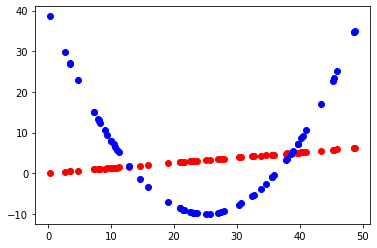

Epoch:  1


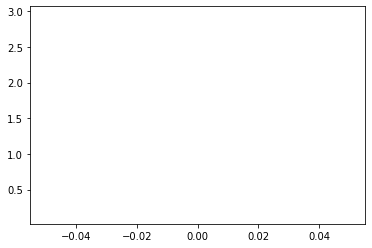

Epoch:  2


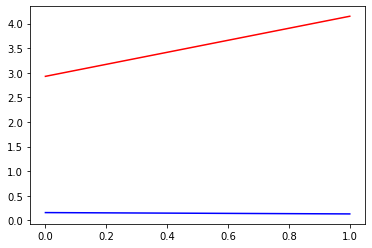

Epoch:  3


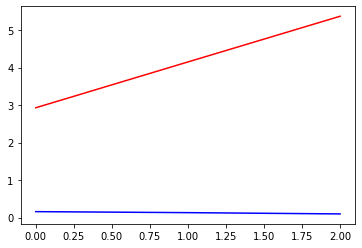

Epoch:  4


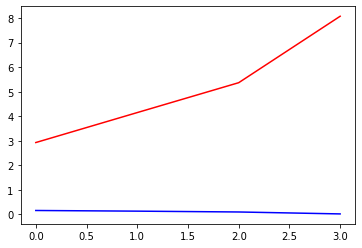

Epoch:  5


KeyboardInterrupt: ignored

In [187]:
ShowCurvePlot()
Training(20)
ShowCurvePlot()
#checkpoint.restore(tf.train.latest_checkpoint(checkpointDir))
#print(testSeed)
#print(generator.predict(testSeed))

# Sine GAN Training

## Training Vars

In [107]:
def S(x):
  return np.around(np.sin(x) * (1 - (x/20)), 2)

def C(x):
  return np.around(np.cos(x) * (1 - (x/20)), 2)


In [108]:
genNoiseDim = 2

In [109]:
batchSize = 64
iterations = 10000

## Networks

Discriminator

In [110]:
sinDiscriminator = Sequential([
    Input(shape=(3)),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

Generator

In [111]:
sinGenerator = Sequential([
      Input(shape=(2)),
      Dense(50, activation='relu', use_bias = True),
      Dense(50, activation='relu'),
      Dense(50, activation='relu'),
      Dense(50, activation='relu'),
      Dense(10, activation='relu'),
      Dense(1)
])

## Training Setup

In [112]:
def SinGenerateRealBatch(size, _curBatch, _noise):
  rBatch = []
  data = np.copy(_noise)
  for i in range(size):
    rBatch.append(S(data[i][0] + 0.25))
  return np.hstack([_curBatch, np.array(rBatch).reshape(size, 1)])

def SinGenerateGeneratorBatch(size, _noise):
  batch = []

  return np.array(batch)

def SinGenerateBatchStart(size, _noise):
  batch = []
  xDat = np.copy(_noise)
  for i in range(size):
    batch.append(C(xDat[i]))
    xDat[i] = S(xDat[i])
  return np.append(xDat, batch, 1)

#noise = np.around(np.random.uniform(0, 2*np.pi, [20, 1]), 2)

#print(np.append(GenerateBatchStart(20, noise), GenerateRealBatch(20, noise), 1))

In [113]:
sinCrossEntropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

sinGenOp = tf.keras.optimizers.Adam(1e-4)
sinDiscOp = tf.keras.optimizers.Adam(1e-4)

def SinDiscLossCalculation(_realResults, _fakeResults):
  fLoss = sinCrossEntropy(tf.zeros_like(_fakeResults), _fakeResults)
  rLoss = sinCrossEntropy(tf.ones_like(_realResults), _realResults)
  return fLoss + rLoss

def SinGenLossCalculation(_fakeResults):
  return sinCrossEntropy(tf.ones_like(_fakeResults), _fakeResults)

In [114]:
checkpointDir = './training_checkpoints'
checkpointPrefix = os.path.join(checkpointDir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=sinGenOp,
                                 discriminator_optimizer=sinDiscOp,
                                 generator=sinGenerator,
                                 discriminator=sinDiscriminator)

In [115]:
@tf.function
def SinTrainingStep():
  curNoise = np.around(np.random.uniform(0, 6.4*np.pi, [batchSize, 1]), 2)
  genBatch = SinGenerateBatchStart(batchSize, curNoise)
  #print(genBatch)
  #print("###############")
  realBatch = SinGenerateRealBatch(batchSize, genBatch, curNoise)
  #print(realBatch)

  with tf.GradientTape() as genGradTapeS, tf.GradientTape() as discGradTapeS:
    generatedBatch = sinGenerator(genBatch)

    realResult = sinDiscriminator(realBatch, training = True)
    fakeResult = sinDiscriminator(tf.experimental.numpy.append(genBatch, generatedBatch, 1), training = True)

    genLoss = SinGenLossCalculation(fakeResult)
    discLoss = SinDiscLossCalculation(realResult, fakeResult)

    genGrads = genGradTapeS.gradient(genLoss, sinGenerator.trainable_variables)
    discGrads = discGradTapeS.gradient(discLoss, sinDiscriminator.trainable_variables)

    sinGenOp.apply_gradients(zip(genGrads, sinGenerator.trainable_variables))
    sinDiscOp.apply_gradients(zip(discGrads, sinDiscriminator.trainable_variables))

    return discLoss, genLoss

In [116]:
def Training(epochs):
  
  dLossA = []
  gLossA = []

  for epoch in range(epochs):
    print("Epoch: ", epoch + 1)

    for i in range(iterations):
      dLoss, gLoss = SinTrainingStep()
    
    dLossA.append(dLoss)
    gLossA.append(gLoss)
    
    if (epoch + 1) % 1 != 0:
      ShowSinPlot()
      #checkpoint.save(file_prefix = checkpointPrefix)
    
    plt.clf()
    plt.plot(dLossA, c = "blue")
    plt.plot(gLossA, c = "red")
    plt.show()


## Test

### Show Plot

In [117]:
def ShowSinPlot():
  plt.clf()
  nums = np.arange(0, 7, 0.25)
  xD = []
  yD = []
  for i in range(nums.shape[0]):
    xD.append(S(nums[i]))
    yD.append(C(nums[i]))
  
  dat = np.stack((xD, yD), axis=1)

  tr = []
  for i in range(nums.shape[0]):
    tr.append(S(nums[i] + 0.25))

  plt.scatter(nums, sinGenerator.predict([dat]), c="red")
  plt.scatter(nums, tr, c="blue")
  plt.show()


### Train

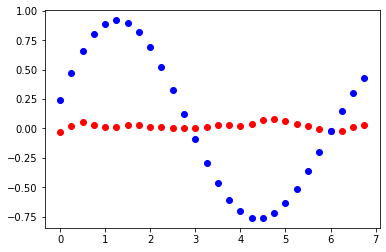

Epoch:  1


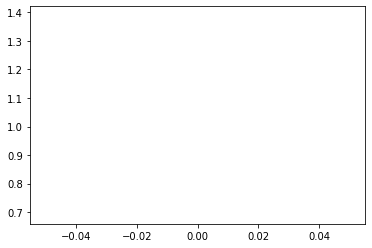

Epoch:  2


KeyboardInterrupt: ignored

In [118]:
ShowSinPlot()
Training(40)
ShowSinPlot()

### Visualise

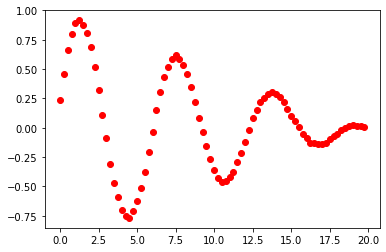

In [121]:
  nums = np.arange(0, 20, 0.25)
  xD = []
  yD = []
  for i in range(nums.shape[0]):
    xD.append(S(nums[i]))
    yD.append(C(nums[i]))
  
  dat = np.stack((xD, yD), axis=1)
  
  plt.scatter(nums, sinGenerator.predict([dat]), c="red")
  plt.show()

#File Read

In [ ]:
fr = AnimFileReader("SHO_EXORCISMWALK_1_UNCLEAN.txt")

In [39]:
data = fr.animData
print(fr.animData.shape)
print(data.shape)
data = np.reshape(data, [221, 168])
print(fr.animData.shape)
print(data.shape)

NameError: ignored